## C S 329E HW 6

# KNN 

## Ella Jiang, Alex Chiu

For this week's homework we are going explore one new classification technique:

  - k nearest neighbors

We are using a different version of the Melbourne housing data set, to predict the housing type as one of three possible categories:

  - 'h' house
  - 'u' duplex
  - 't' townhouse

At the end of this homework, I expect you to understand how to build and use a kNN model, and practice your data cleaning and data preparation skills. 

In [1]:
# These are the libraries you will use for this assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
%matplotlib inline

# Starting off loading a training set
df_melb = pd.read_csv('melb_data_train.csv')

## Q1 - Fix a column of data to be numeric
If we inspect our dataframe, `df_melb` using the `dtypes` method, we see that the column "Date" is an object.  However, we think this column might contain useful information so we want to convert it to [seconds since epoch](https://en.wikipedia.org/wiki/Unix_time). Use only the exiting imported libraries to create a new column "unixtime". Be careful, the date strings in the file might have some non-uniform formatting that you have to fix first.  Print out the min and max epoch time to check your work.  Drop the original "Date" column. Please use the python [reference for time](https://docs.python.org/3/library/time.html) to help you do the string to Unix time conversion. 

In [2]:
# normalize date accepts the date string as shown in the df_melb 'Date' column,
# and returns a data in a standarized format
def standardize_date(d):
    dSplit = d.split("/")
    newD = "";
    if len(dSplit[0])!=2:
        newD = newD + "0"
    newD = newD + dSplit[0]+"/"
    if len(dSplit[1])!=2:
        newD = newD + "0"
    newD = newD + dSplit[1]+"/"
    if len(dSplit[2])!=4:
        newD = newD + "20"
    newD = newD + dSplit[2]
    return newD
    # Your code here
    


In [3]:
df_melb['Date'] = df_melb['Date'].apply( lambda x : standardize_date(x)) 
df_melb['unixtime'] = pd.to_datetime(df_melb['Date'], format='%d/%m/%Y')

df_melb['unixtime'] = df_melb['unixtime'].apply( lambda x : int(x.timestamp())) 


print(df_melb['unixtime'].head(10))
print(df_melb['Date'].head(10))


0    1462579200
1    1472342400
2    1499472000
3    1498262400
4    1479513600
5    1499472000
6    1466985600
7    1494028800
8    1462579200
9    1494028800
Name: unixtime, dtype: int64
0    07/05/2016
1    28/08/2016
2    08/07/2017
3    24/06/2017
4    19/11/2016
5    08/07/2017
6    27/06/2016
7    06/05/2017
8    07/05/2016
9    06/05/2017
Name: Date, dtype: object


In [4]:

df_melb = df_melb.drop(columns="Date")

print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_melb['unixtime'].min(),df_melb['unixtime'].max()))

The min unixtime is 1454544000 and the max unixtime is 1506124800


## Q2 Use Imputation to fill in missing values
kNN doesn't work when the attributes are not valid for all of the attribute columns, so fill in all the missing values in `df_melb` with the mean of that column.  Save the mean of each column in a dictionary, `dict_imputation`, whose key is the attribute column name, so we can apply the same imputation to the test set later. Show your `dict_imputation` dictionary and the head of your `df_melb` dataframe.  The target classfication (aka the class label) is stored in the column `'Type'`, so we are going to define a variable target_col so we can reference the target_col using a variable. (hint: during imputation you skip the target column)

In [5]:
target_col = 'Type'
df_melb

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,h,399000,8.7,3032,1,1.0,904,53.0,1985.0,1462579200
1,3,h,1241000,13.9,3165,1,1.0,643,NaN,NaN,1472342400
2,2,u,550000,3.0,3067,1,1.0,1521,NaN,NaN,1499472000
3,3,u,691000,8.4,3072,1,1.0,170,NaN,NaN,1498262400
4,2,u,657500,4.6,3122,1,1.0,728,73.0,1965.0,1479513600
...,...,...,...,...,...,...,...,...,...,...,...
495,2,t,710000,7.2,3184,1,1.0,0,NaN,1980.0,1501286400
496,2,u,446000,8.0,3040,1,1.0,0,NaN,NaN,1460764800
497,3,h,887000,9.2,3058,1,2.0,560,NaN,NaN,1491609600
498,3,h,1365000,8.0,3040,1,1.0,754,NaN,NaN,1462579200


In [6]:
dict_imputation = dict()

for col in df_melb.columns:
    if col == target_col:
        continue
    mean= df_melb[col].mean()
    dict_imputation[col]=mean
    df_melb[col] = df_melb[col].fillna(value = mean)
    #print(col + " "+ str(mean))
    # your code here


In [7]:
dict_imputation

{'Rooms': 2.71,
 'Price': 932558.7,
 'Distance': 10.524599999999985,
 'Postcode': 3113.122,
 'Bathroom': 1.44,
 'Car': 1.503006012024048,
 'Landsize': 638.91,
 'BuildingArea': 121.7832,
 'YearBuilt': 1970.9417475728155,
 'unixtime': 1485178502.4}

In [8]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,h,399000,8.7,3032,1,1.0,904,53.0000,1985.000000,1462579200
1,3,h,1241000,13.9,3165,1,1.0,643,121.7832,1970.941748,1472342400
2,2,u,550000,3.0,3067,1,1.0,1521,121.7832,1970.941748,1499472000
3,3,u,691000,8.4,3072,1,1.0,170,121.7832,1970.941748,1498262400
4,2,u,657500,4.6,3122,1,1.0,728,73.0000,1965.000000,1479513600


## Q3 Normalize all the attributes to be between [0,1]
Normalize all the attribute columns in `df_melb` so they have a value between zero and one (inclusive). Save the (min,max) tuple used to normalize to a dictionary, `dict_normalize`, so we can apply it to the test set later.  The dataframe `df_melb` is now your "model" that you can use to classify new data points. (hint: during normalization you skip the class label column)

In [9]:
dict_normalize = dict()
for col in df_melb.columns:
    if col == target_col:
        continue
    colMax = df_melb[col].max()
    colMin = df_melb[col].min()
    colRange = colMax-colMin
    dict_normalize[col]=tuple((colMin,colMax))
    df_melb[col] = df_melb[col].apply( lambda x : (x-colMin)/colRange) 

    # your code here

In [10]:
dict_normalize

{'Rooms': (1, 6),
 'Price': (291000, 5020000),
 'Distance': (0.7, 47.3),
 'Postcode': (3002, 3810),
 'Bathroom': (0, 4),
 'Car': (0.0, 4.0),
 'Landsize': (0, 41400),
 'BuildingArea': (0.0, 475.0),
 'YearBuilt': (1890.0, 2015.0),
 'unixtime': (1454544000, 1506124800)}

In [11]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.2,h,0.022838,0.171674,0.037129,0.25,0.25,0.021836,0.111579,0.760000,0.155779
1,0.4,h,0.200888,0.283262,0.201733,0.25,0.25,0.015531,0.256386,0.647534,0.345059
2,0.2,u,0.054768,0.049356,0.080446,0.25,0.25,0.036739,0.256386,0.647534,0.871022
3,0.4,u,0.084584,0.165236,0.086634,0.25,0.25,0.004106,0.256386,0.647534,0.847571
4,0.2,u,0.077501,0.083691,0.148515,0.25,0.25,0.017585,0.153684,0.600000,0.484087


## Q4 Load in the Test data and prep it for classification
Everything we did to our "train" set, we need to now do in our "test" set. 

In [12]:
df_test = pd.read_csv("melb_data_test.csv")

In [13]:
# Your code here to fix date
df_test['Date'] = df_test['Date'].apply( lambda x : standardize_date(x)) 
df_test['unixtime'] = pd.to_datetime(df_test['Date'], format='%d/%m/%Y')

df_test['unixtime'] = df_test['unixtime'].apply( lambda x : int(x.timestamp())) 
df_test = df_test.drop(columns="Date")


print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_test['unixtime'].min(),df_test['unixtime'].max()))


The min unixtime is 1454544000 and the max unixtime is 1506124800


In [14]:
# Your code here for imputation - must use dictionary from above!
for col in df_test.columns:
    if col == target_col:
        continue
    #mean= df_melb[col].mean()
    #dict_imputation[col]=mean
    df_test[col] = df_test[col].fillna(value = dict_imputation[col])
    
df_test.head()        

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,3,h,1116000,17.9,3192,1,2.0,610,121.7832,1970.941748,1498867200
1,3,h,2030000,11.2,3186,2,2.0,366,121.7832,1970.941748,1472342400
2,3,h,1480000,10.7,3187,2,2.0,697,143.0000,1925.000000,1478476800
3,3,u,1203500,12.3,3166,2,2.0,311,127.0000,2000.000000,1495843200
4,3,h,540000,14.7,3030,2,2.0,353,135.0000,2011.000000,1504396800


In [15]:
# Your code here for scaling - must use dictionary from above!
for col in df_test.columns:
    if col == target_col:
        continue
    colMax = dict_normalize[col][1]
    colMin = dict_normalize[col][0]
    colRange = colMax-colMin
    #dict_normalize[col]=tuple((colMin,colMax))
    df_test[col] = df_test[col].apply( lambda x : (x-colMin)/colRange) 


df_test.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.4,h,0.174455,0.369099,0.235149,0.25,0.5,0.014734,0.256386,0.647534,0.859296
1,0.4,h,0.367731,0.225322,0.227723,0.50,0.5,0.008841,0.256386,0.647534,0.345059
2,0.4,h,0.251427,0.214592,0.228960,0.50,0.5,0.016836,0.301053,0.280000,0.463987
3,0.4,u,0.192958,0.248927,0.202970,0.50,0.5,0.007512,0.267368,0.880000,0.800670
4,0.4,h,0.052654,0.300429,0.034653,0.50,0.5,0.008527,0.284211,0.968000,0.966499


## Q5 Write the kNN classifier function
Your function `knn_class`, should take five parameters, the training dataframe (that includes the target column), the hyper parameter `k`, the name of the target column, a single observation row (a series or attributes the same length as the attributes in `df_train`) of the test dataframe, and a boolean `use_weighted_vote`.  When `use_weighted_vote` is set to true, use weighted voting, otherwise use majority voting. We are assuming that the parameter `df_train` contains all of the attributes, and the target class in the same dataframe. The function returns the predicted target classification for that observation. To find the distance between the single observation and the training data frame you should use the [L2 norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

In [48]:
def knn_class(df_train, k, target_col, observation, use_weighted_vote ):
    #idx = df_train.columns.get_loc(target_col)
    test = df_train.drop(columns=target_col)
    #print(observation.drop(target_col))
    ob = observation.drop(target_col)
    types = df_train[target_col].unique()
    #print(types)
    norm = np.linalg.norm(test-ob,axis=1)
    idx=np.argpartition(norm,k) #idx contains the k smallest values in the first k indicies
    #print(norm[idx[:k]]) #this prints the smallest k values in norm
    voting = np.zeros(len(types))

    if(use_weighted_vote):
        for i in range(len(types)):
            t = types[i]
            for j in idx[:k]:
                if (df_train.iloc[j][target_col]==t):
                    voting[i]+=1/(norm[j])**2;
    else:
        for i in range(len(types)):
            t = types[i]
            for j in idx[:k]:
                if (df_train.iloc[j][target_col]==t):
                    voting[i]+=1
    votingMax = voting.max()
    for i in range(len(types)):
        if votingMax==voting[i]:
            return types[i]

knn_class(df_melb,3,"Type",df_test.iloc[1],True)

't'

In [27]:
#knn_class(df_melb,3,"Type",df_test.iloc[0],False)
#ob =df_test.iloc[1]
#print(ob.drop("Type"))
#print(np.array(ob.drop("Type")))

## Q6 Compute the accuracy using different k values
For each value of $k$ in the set $\{1,3,13,25,50,100\}$ calculate the class prediction for each oberservation in the test set, and the overall accuracy of the classifier.  Plot the accuracy as a function of $k$ when `use_weighted_vote` is `True` and when `use_weighted_vote` is `False`.

Which value of $k$ would you chose, and would you use weighted voting or majority voting?

Note, this took 5 minutes on my computer. 

In [56]:
poss_k = [1,3,13,25,50,100] # possible k's
acc_k_majority = list(np.zeros(len(poss_k))) # Accuracy for each value of k using majority voting
acc_k_weighted = list(np.zeros(len(poss_k))) # Accuracy for each value of k using weighted voting

for i in range(len(poss_k)):
    weightedAcc = 0;
    majorityAcc = 0;
    k = poss_k[i]
    for j in range(len(df_test)):
        test_data = df_test.iloc[j]
        test_type = test_data["Type"]
        w = knn_class(df_melb,k,"Type",test_data,True)
        m = knn_class(df_melb,k,"Type",test_data,False)
        if w == test_type:
            weightedAcc+=1
        if m == test_type:
            majorityAcc+=1
    weightedAcc/=len(df_test)
    majorityAcc/=len(df_test)
    acc_k_weighted[i]=weightedAcc
    acc_k_majority[i]=majorityAcc
    print(weightedAcc)
    print(majorityAcc)

# Your code here

0.67
0.67
0.73
0.71
0.71
0.69
0.7
0.7
0.7
0.68
0.7
0.69


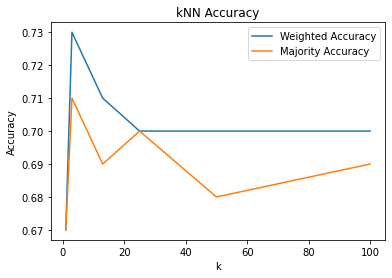

In [61]:
# plot code here
plt.plot(poss_k,acc_k_weighted)
plt.plot(poss_k,acc_k_majority)
plt.legend(["Weighted Accuracy", "Majority Accuracy"])
plt.title("kNN Accuracy")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

➡️ Answer containing your analysis of the I would choose $k = <value> $ and voting scheme because _reasons_ here ⬅️